# indice_secteur 爬虫抓取investir

### parametre

In [24]:
#爬虫配置spider
from bs4 import BeautifulSoup
import re 
import requests

from selenium import webdriver
import warnings
import time
from selenium.webdriver.support.ui import Select

#base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


#显示全部变量
from IPython.core.interactiveshell import InteractiveShell
import openpyxl
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('max_columns',1000)
pd.set_option('max_row',30)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

%matplotlib inline 
#让图表直接在Jupyter Notebook中展示出来 
plt.rcParams['font.sans-serif'] = 'SimHei' # 解决中文乱码问题 
plt.rcParams['axes.unicode_minus'] = False # 解决负号无法显示的问题 
%config InlineBackend.figure_format = 'svg' # 矢量图，更清晰

### requests 数据抓取

In [107]:

#5ans : https://lesechos-bourse-fo-cdn.wlb.aw.atos.net/cours/ajax-historique-from-period?code=QS0011017686&place=XPAR&codif=ISIN&isOrderEvent=false&dureecours=-60&periodecours=DAY&datecours=&_=1583949616670
#3ans: https://lesechos-bourse-fo-cdn.wlb.aw.atos.net/cours/ajax-historique-from-period?code=QS0011017686&place=XPAR&codif=ISIN&isOrderEvent=false&dureecours=-36&periodecours=DAY&datecours=&_=1583950226584
import requests
import json

#填写：a remplir


urls={'CAC Pétrole et Gaz':'https://lesechos-bourse-fo-cdn.wlb.aw.atos.net/cours/ajax-historique-from-period?code=QS0011017603&place=XPAR&codif=ISIN&isOrderEvent=false&dureecours=-60&periodecours=DAY&datecours=&_=1583963103320',
      'CAC Industries':'https://lesechos-bourse-fo-cdn.wlb.aw.atos.net/cours/ajax-historique-from-period?code=QS0011017652&place=XPAR&codif=ISIN&isOrderEvent=false&dureecours=-60&periodecours=DAY&datecours=&_=1583963281412',
      'CAC Matériaux de Base':'https://lesechos-bourse-fo-cdn.wlb.aw.atos.net/cours/ajax-historique-from-period?code=QS0011017637&place=XPAR&codif=ISIN&isOrderEvent=false&dureecours=-60&periodecours=DAY&datecours=&_=1583963331990',
      'CAC Biens de Consommation':'https://lesechos-bourse-fo-cdn.wlb.aw.atos.net/cours/ajax-historique-from-period?code=QS0011017686&place=XPAR&codif=ISIN&isOrderEvent=false&dureecours=-60&periodecours=DAY&datecours=&_=1583954969018',
      'CAC Services aux Consommateurs':'https://lesechos-bourse-fo-cdn.wlb.aw.atos.net/cours/ajax-historique-from-period?code=QS0011017736&place=XPAR&codif=ISIN&isOrderEvent=false&dureecours=-60&periodecours=DAY&datecours=&_=1583963423920',
      'CAC Santé':'https://lesechos-bourse-fo-cdn.wlb.aw.atos.net/cours/ajax-historique-from-period?code=QS0011017702&place=XPAR&codif=ISIN&isOrderEvent=false&dureecours=-60&periodecours=DAY&datecours=&_=1583963480694',
      'CAC Sociétés Financières':'https://lesechos-bourse-fo-cdn.wlb.aw.atos.net/cours/ajax-historique-from-period?code=QS0011017801&place=XPAR&codif=ISIN&isOrderEvent=false&dureecours=-60&periodecours=DAY&datecours=&_=1583963569489',
      'CAC Services aux Collectivités':'https://lesechos-bourse-fo-cdn.wlb.aw.atos.net/cours/ajax-historique-from-period?code=QS0011017785&place=XPAR&codif=ISIN&isOrderEvent=false&dureecours=-60&periodecours=DAY&datecours=&_=1583963621661',
      'CAC Télécommunications':'https://lesechos-bourse-fo-cdn.wlb.aw.atos.net/cours/ajax-historique-from-period?code=QS0011017769&place=XPAR&codif=ISIN&isOrderEvent=false&dureecours=-60&periodecours=DAY&datecours=&_=1583963665933',
     }
headers={'Accept':'application/json, text/javascript, */*; q=0.01',
'Accept-Encoding':'gzip, deflate, br',
'Accept-Language':'zh-CN,zh;q=0.9',
'Connection':'keep-alive',
'Host':'lesechos-bourse-fo-cdn.wlb.aw.atos.net',
'Origin':'https://investir.lesechos.fr',
'Referer':'https://investir.lesechos.fr/cours/historique-indice-cac-biens-de-consommation,xpar,frcg,qs0011017686,isin.html',
'Sec-Fetch-Dest':'empty',
'Sec-Fetch-Mode':'cors',
'Sec-Fetch-Site':'cross-site',
'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.122 Safari/537.36'
         }


writer=pd.ExcelWriter(r'export/indice_sectoriel.xlsx')

def requests_html(url,headers):
    """
    请求网页代码
    """
    html=requests.get(url,headers=headers,verify=False)
    #####解决requests模块使用过程中遇到 certificate verify failed 错误:verify=False
    html.raise_for_status()
    html.encoding=html.apparent_encoding
        #print(html.text)
        #print(html.encoding)#抓取下来的编码utf-8
        #print(html.apparent_encoding)#网页原编码 utf-8
    requests.packages.urllib3.disable_warnings() 
    ######解决requests模块使用过程中遇到 certificate verify failed 错误
    return html

for k,v in urls.items():
    secteur_name=k
    url=v
    r =requests_html(url,headers).text
    data=json.loads(r)

    data=data['aaData']
    column=pd.DataFrame(['Date','Dernier','Var.%','+haut','+bas','Ouverture']).T
    #print(column)
    column=list(column.loc[0]) #['Date', 'Dernier', 'Var.%', '+haut', '+bas', 'Ouverture']

    data=pd.DataFrame(data,columns=column)
    data.head()  

    #循环前： writer=pd.ExcelWriter(r'export/indice_sectoriel.xlsx')
    ==>#data.to_excel(writer,sheet_name='{}'.format(secteur_name)) #ligne executer

SyntaxError: invalid syntax (<ipython-input-107-5630d1501147>, line 66)

# tableau thermique

### calcule corr

In [115]:
# x = correlation
data=pd.read_excel(r'export/indice_sectoriel_net.xlsx')
x=data.corr()
x

,Petrole & gaz,Industries,Materiaux,Consomation,Services conso,Sante,Finance,Service aux collectivite,Telecommunication
Petrole & gaz,1.00000,0.55791,0.74083,0.52635,0.61427,0.27448,0.38188,0.09591,0.31534
Industries,0.55791,1.00000,0.73141,0.98042,0.78439,0.56412,0.33593,-0.00698,0.39285
Materiaux,0.74083,0.73141,1.00000,0.62766,0.73515,0.44634,0.74329,0.08869,0.28866
Consomation,0.52635,0.98042,0.62766,1.00000,0.74294,0.52024,0.17361,-0.01917,0.36710
Services conso,0.61427,0.78439,0.73515,0.74294,1.00000,0.64804,0.51568,0.46841,0.45165
Sante,0.27448,0.56412,0.44634,0.52024,0.64804,1.00000,0.39566,0.40726,0.26363
Finance,0.38188,0.33593,0.74329,0.17361,0.51568,0.39566,1.00000,0.10543,0.31416
Service aux collectivite,0.09591,-0.00698,0.08869,-0.01917,0.46841,0.40726,0.10543,1.00000,0.12512
Telecommunication,0.31534,0.39285,0.28866,0.36710,0.45165,0.26363,0.31416,0.12512,1.00000


### visueliser le tableau thermique

([<matplotlib.axis.XTick at 0x124b84320>,
 <a list of 9 Text xticklabel objects>)

([<matplotlib.axis.YTick at 0x124bb39b0>,
 <a list of 9 Text yticklabel objects>)

Text(0.5,1,'correlation des indices sectoriels')

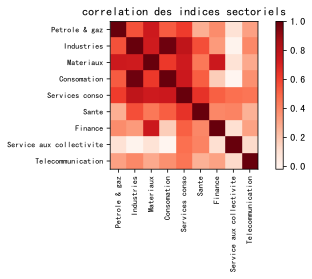

In [134]:
#tableau thermique

fig=plt.Figure(figsize=(50,30))
cmap=plt.cm.Reds        #couleur
plt.imshow(x,cmap=cmap) #订正：是x或者result.corr(),不是result

plt.colorbar()          #订正：colorbar 要放在imshow热力图后显示

industry=x.columns.values          #获取替换的名称,列标题
tickmarks=np.arange(len(industry)) #修改轴的数字与名称个数一一对应
plt.xticks(tickmarks,industry,rotation=90,fontsize=8)#x轴替换
plt.yticks(tickmarks,industry,rotation=0,fontsize=8) #y轴

plt.title('correlation des indices sectoriels',fontsize=12,loc='center')# title 要放在xlabel前 ？

#plt.xlabel(fontsize=3) 
#报错：xlabel() missing 1 required positional argument: 's'，第一个参数为x轴标签


plt.tight_layout() #订正：解决x轴标签过大，保存图片显示不全的问题
plt.savefig(r'picture/indice_sectoriel_corr.png',dpi=500)#订正不清晰：指定分辨率plt.savefig(dpi=500)